In [1]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
import densite

# **Load files**

### 1.1 - Predictions

In [2]:
zos    = np.load("/data/mtissot/simus_predicted/zos.npy")       #sea surface height  = ssh  t*y*x
so     = np.load("/data/mtissot/simus_predicted/so.npy")        #salinity t*z*y*x
thetao = np.load("/data/mtissot/simus_predicted/thetao.npy")    #temperature t*z*y*x

In [3]:
print(np.shape(zos))
print(np.shape(so))
print(np.shape(thetao))

(30, 331, 360)
(30, 75, 331, 360)
(30, 75, 331, 360)


In [4]:
xr_zos    = xr.DataArray(zos, dims=("time_counter", "y", "x"), name="zos")
xr_so     = xr.DataArray(so, dims=("time_counter", "deptht", "y", "x"), name="so")
xr_thetao = xr.DataArray(thetao, dims=("time_counter", "deptht", "y", "x"), name="thetao")

### 1.2 - Maskdataset

In [5]:
#Mask informations for each grid
MASKdataset    = xr.open_dataset('/thredds/idris/work/ues27zx/eORCA1.4.2_mesh_mask_modJD.nc',decode_times=False) 
print("features : ", list(MASKdataset.keys()))

features :  ['e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'e3f_0', 'e3t_0', 'e3t_1d', 'e3u_0', 'e3uw_0', 'e3v_0', 'e3vw_0', 'e3w_0', 'e3w_1d', 'ff_f', 'ff_t', 'fmask', 'gdept_0', 'gdept_1d', 'gdepw_0', 'gdepw_1d', 'glamf', 'glamt', 'glamu', 'glamv', 'gphif', 'gphit', 'gphiu', 'gphiv', 'mbathy', 'misf', 'nav_lev', 'time_counter', 'tmask', 'tmaskutil', 'umask', 'umaskutil', 'vmask', 'vmaskutil', 'gridx', 'gridy']


### 1.3 - Restart file

x slice  :  slice(57, 76, None)
y slice  :  slice(238, 252, None)

features :  ['xx', 'yy', 'kt', 'ndastp', 'adatrj', 'ntime', 'fwfisf_par_b', 'isf_hc_par_b', 'isf_sc_par_b', 'nn_fsbc', 'ssu_m', 'ssv_m', 'sst_m', 'sss_m', 'ssh_m', 'e3t_m', 'frq_m', 'rnf_b', 'rnf_hc_b', 'rnf_sc_b', 'utau_b', 'vtau_b', 'qns_b', 'emp_b', 'sfx_b', 'en', 'avt_k', 'avm_k', 'dissl', 'ub2_b', 'vb2_b', 'un_bf', 'vn_bf', 'sbc_hc_b', 'sbc_sc_b', 'qsr_hc_b', 'fraqsr_1lev', 'frc_v', 'frc_t', 'frc_s', 'surf_ini', 'ssh_ini', 'e3t_ini', 'tmask_ini', 'hc_loc_ini', 'sc_loc_ini', 'rdt', 'sshb', 'ub', 'vb', 'tb', 'sb', 'sshn', 'un', 'vn', 'tn', 'sn', 'rhop']


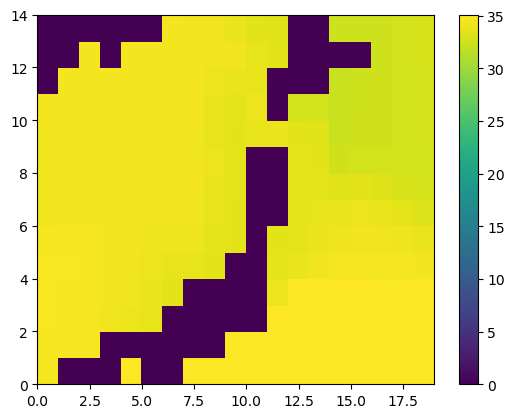

In [6]:
restarts_file = "/thredds/idris/work/ues27zx/Restarts/"
restart_name  = "OCE_CM65v420-LR-CdL-pi-01_19141231_restart_0250.nc"  #pour chaque fichier de restart 
Restart       = xr.open_dataset(restarts_file+restart_name,decode_times=False)

# Définition de la zone géographique
First   = Restart.DOMAIN_position_first  
Last    = Restart.DOMAIN_position_last
x_slice = slice(First[0]-1,Last[0])
y_slice = slice(First[1]-1,Last[1])

print("x slice  : ",x_slice)
print("y slice  : ",y_slice)
print("\nfeatures : ", list(Restart.keys()))

plt.pcolor(Restart["sn"][-1,0,:,:])
plt.colorbar()

## Update one restart file

### 2.1 - zos, so and Thetao update

In [8]:
#Changement des variables de restart now 
Restart['sshn'] = xr_zos[-1:,y_slice,x_slice]
Restart['sn']   = xr_so[-1:,:,y_slice,x_slice]
Restart['tn']   = xr_thetao[-1:,:,y_slice,x_slice]

#Changement des variables de restart now 
Restart['sshb'] = xr_zos[-1:,y_slice,x_slice]
Restart['sb']   = xr_so[-1:,:,y_slice,x_slice]
Restart['tb']   = xr_thetao[-1:,:,y_slice,x_slice]

#
Restart['sss_m'] = xr_so[-1:,0,y_slice,x_slice]
Restart['sst_m'] = xr_thetao[-1:,0,y_slice,x_slice]

### 2.2 - e3t and deptht

In [9]:
e3t = MASKdataset["e3t_0"].values[0]  #diff e3t /depth ?

array  = xr.open_dataset("/scratchu/mtissot/SIMUp6Y/CM65v420-LR-CdL-pi-01_18500101_19491231_1M_so.nc.YAVG.nc" , decode_times=False)
deptht = np.tile(array.deptht.values, (1,360,331,1)).transpose(0,3,2,1)  #thickness of all 75 levels


print(np.shape(deptht))
print(np.shape(e3t))

"""
#Extraction Poids
e3t_ini=Restart.variables['e3t_ini']                                  # Poids au départ 
ssmask=np.max(MASKdataset.tmask.values[:,:,y_slice,x_slice],axis=1)   # Présence de flotte dans la colonne, pour éviter //0
bathy=np.ma.sum(e3t_ini,axis=1)                                       # Bathymétrie au départ
ssh=Restart.variables['ssh_m']                                        # Sea Surface Height entre Before et Now (?)
tmask4D=MASKdataset.tmask.values[:,:,y_slice,x_slice]                 # Présence de flotte sur grille T
e3t=e3t_ini*(1+tmask4D*np.expand_dims(np.tile(ssh*ssmask/(bathy+(1-ssmask)),(75,1,1)),axis=0)) # On proportionne les poids pour la nouvelle bathymétrie : *(bathy+ssh)/bathy
e2u=MASKdataset.e2u[:,y_slice,x_slice]
e1v=MASKdataset.e1v[:,y_slice,x_slice]
tmask=MASKdataset.tmask[0,0,y_slice,x_slice]
umask=MASKdataset.umask[0,0,y_slice,x_slice]
vmask=MASKdataset.vmask[0,0,y_slice,x_slice]
fmask=MASKdataset.fmask[0,0,y_slice,x_slice]
newbathy=np.ma.sum(e3t,axis=1)
"""

(1, 75, 331, 360)
(75, 331, 360)


"\n#Extraction Poids\ne3t_ini=Restart.variables['e3t_ini']                                  # Poids au départ \nssmask=np.max(MASKdataset.tmask.values[:,:,y_slice,x_slice],axis=1)   # Présence de flotte dans la colonne, pour éviter //0\nbathy=np.ma.sum(e3t_ini,axis=1)                                       # Bathymétrie au départ\nssh=Restart.variables['ssh_m']                                        # Sea Surface Height entre Before et Now (?)\ntmask4D=MASKdataset.tmask.values[:,:,y_slice,x_slice]                 # Présence de flotte sur grille T\ne3t=e3t_ini*(1+tmask4D*np.expand_dims(np.tile(ssh*ssmask/(bathy+(1-ssmask)),(75,1,1)),axis=0)) # On proportionne les poids pour la nouvelle bathymétrie : *(bathy+ssh)/bathy\ne2u=MASKdataset.e2u[:,y_slice,x_slice]\ne1v=MASKdataset.e1v[:,y_slice,x_slice]\ntmask=MASKdataset.tmask[0,0,y_slice,x_slice]\numask=MASKdataset.umask[0,0,y_slice,x_slice]\nvmask=MASKdataset.vmask[0,0,y_slice,x_slice]\nfmask=MASKdataset.fmask[0,0,y_slice,x_slice]\nnewbathy=

### 2.3 - rhop update

In [12]:
rho_insitu = densite.insitu(thetao[-1:],so[-1:],deptht)  
rhop       = densite.sigma_n(thetao[-1:],so[-1:],n=0)

print(np.shape(rho_insitu))
print(np.shape(rhop))

xr_rho_insitu = xr.DataArray(rho_insitu, dims=("time_counter", "deptht", "y", "x"), name="rho_insitu")
xr_rhop       = xr.DataArray(rhop, dims=("time_counter", "deptht", "y", "x"), name="rhop")

Restart['rhop'] = xr_rhop[-1:,0,y_slice,x_slice]

(1, 75, 331, 360)
(1, 75, 331, 360)


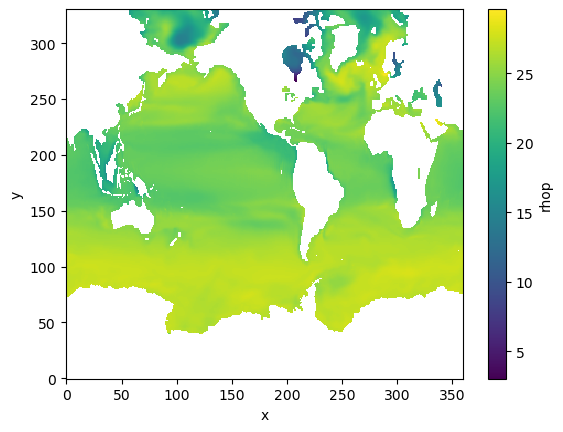

In [13]:
xr_rhop.isel(time_counter=0, deptht=0).plot(x='x', y='y')

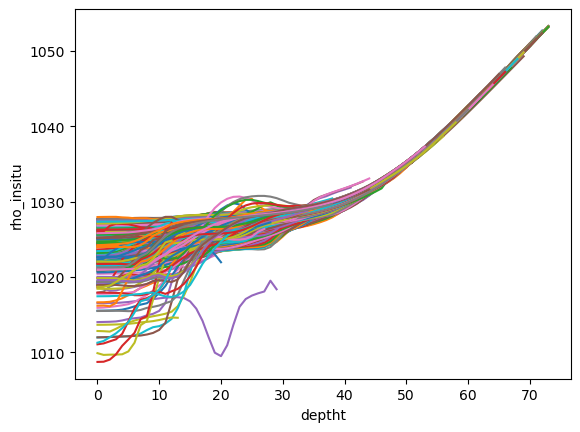

In [14]:
for i in range(0,331,10):
    for j in range(0,360,10):
        slice_data = xr_rho_insitu.isel(time_counter=0, x=j, y=i).plot()
# observation de l'evolution de la densité en profondeur

(75, 331, 360)
(74, 331, 360)
(74, 331, 360)


/tmp/ipykernel_262569/2897333606.py:8: RuntimeWarning: All-NaN slice encountered
  plt.pcolor(np.nanmin(diff_rho_insitu_z, axis=0) < 0, alpha=alpha_values)  # Plot with transparency


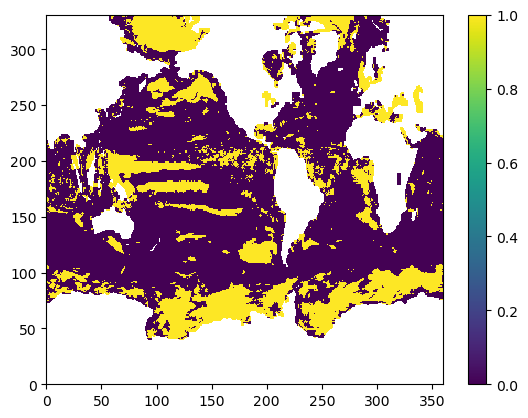

In [15]:
diff_rho_insitu_z = np.diff(rho_insitu[-1], axis=0)/e3t[:-1] #differentiel de la densité

print(np.shape(rho_insitu[-1]))
print(np.shape(e3t[:-1]))
print(np.shape(diff_rho_insitu_z))

alpha_values = np.where(np.isnan(zos[-1]), 0, 1.0)  
plt.pcolor(np.nanmin(diff_rho_insitu_z, axis=0) < 0, alpha=alpha_values)  # Plot with transparency
plt.colorbar()
plt.show()

### 2.4 - velocities update

In [17]:
#Changement des variables de restart now : vitesses
vn    = Restart.variables['vn'] 
un    = Restart.variables['un']   

e3t   = MASKdataset["e3t_0"].values[0]   #depth 
e2t   = MASKdataset["e2t"].values[0]     #? 
e1t   = MASKdataset["e1t"].values[0]     #? Explication grilles , indices 1,2,3, ???? Guillaume
umask = MASKdataset["umask"].values
vmask = MASKdataset["vmask"].values

#equation from ... p...
diff_x = -np.roll(rho_insitu,shift=1,axis=2) + rho_insitu
v      = 9.81/(rho_insitu*MASKdataset["ff_f"].values) * np.cumsum(diff_x*e3t/e1t,axis=0)   #V_0  

#equation from ... p...
diff_y = np.roll(rho_insitu[-1],shift=-1,axis=1) - rho_insitu[-1] # * e2t
u      = 9.81/(rho_insitu[-1]*MASKdataset["ff_f"].values) * np.cumsum(diff_y*e3t/e2t,axis=0)   #+ U_0

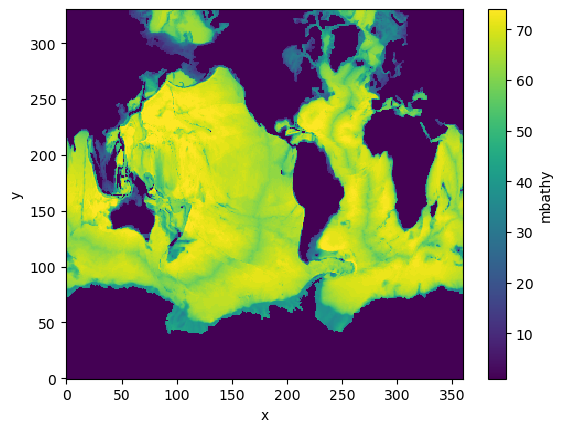

In [103]:
MASKdataset.mbathy.plot()

In [ ]:
#We get V0 : the speed at the bottom of the original restart file 
#hypothesis : V0 is constant t,x,y
#

            #if umask[-1,k,j,i]==1 : print("u")
#Un = U + U_0
"""               
for i in range(un.sizes['x']):
    for j in range(un.sizes['y']):#range(y_slice.start, y_slice.stop):
        u0=False
        for k in range(0,75,-1):
            if umask[-1,k,j,i]==1 : print("u")
            if umask[-1,k,j,i]==1 and u0==False: #toujours#0
                u0 = un[-1,k,j,i]
                print("u")   
            elif umask[-1,k,j,i]==1 and np.isnan(u[k-1,j,i])==False:
                un = u0+ u[k-1,j,i]
                print("u")
                
for i in range(vn.sizes['x']):
    for j in range(vn.sizes['y']):#range(y_slice.start, y_slice.stop):
        v0=False
        for k in range(0,75,-1):
            if vmask[-1,k,j,i]==1 and v0==False:
                v0=vn[-1,k,j,i]
                
            elif vmask[-1,k,j,i]==1 and np.isnan(v[k-1,j,i])==False:
                vn= u0+ u[k-1,j,i]
"""

Restart['un']  = un
Restart['vn']  = vn
Restart['ssu_m'] = un[0]     
Restart['ssv_m'] = vn[0] 

In [ ]:
MASKdataset = xr.open_dataset('eORCA1.4.2_mesh_mask_modJD.nc',decode_times=False)


for num in range(340):
    print(num)
    Restart = xr.open_dataset(sys.argv[1]+sys.argv[2]+'%04d.nc'%num,decode_times=False)

    # Définition de la zone géographique
    First=Restart.DOMAIN_position_first
    Last=Restart.DOMAIN_position_last
    x_slice=slice(First[0]-1,Last[0])
    y_slice=slice(First[1]-1,Last[1])

    #Extraction vitesses
    un=Restart.variables['un']
    vn=Restart.variables['vn']

    #Extraction Poids
    e3t_ini=Restart.variables['e3t_ini']                                  # Poids au départ 
    ssmask=np.max(MASKdataset.tmask.values[:,:,y_slice,x_slice],axis=1)   # Présence de flotte dans la colonne, pour éviter //0
    bathy=np.ma.sum(e3t_ini,axis=1)                                       # Bathymétrie au départ
    ssh=Restart.variables['ssh_m']                                        # Sea Surface Height entre Before et Now (?)
    tmask4D=MASKdataset.tmask.values[:,:,y_slice,x_slice]                 # Présence de flotte sur grille T
    e3t=e3t_ini*(1+tmask4D*np.expand_dims(np.tile(ssh*ssmask/(bathy+(1-ssmask)),(75,1,1)),axis=0)) # On proportionne les poids pour la nouvelle bathymétrie : *(bathy+ssh)/bathy
    e2u=MASKdataset.e2u[:,y_slice,x_slice]
    e1v=MASKdataset.e1v[:,y_slice,x_slice]
    tmask=MASKdataset.tmask[0,0,y_slice,x_slice]
    umask=MASKdataset.umask[0,0,y_slice,x_slice]
    vmask=MASKdataset.vmask[0,0,y_slice,x_slice]
    fmask=MASKdataset.fmask[0,0,y_slice,x_slice]
    newbathy=np.ma.sum(e3t,axis=1)

    #Calcul composante barotrope
    Un=np.ma.sum(un*e3t,axis=1)/newbathy
    Vn=np.ma.sum(vn*e3t,axis=1)/newbathy

    # Baroclinisation
    un-=Un*umask.to_numpy()
    vn-=Vn*vmask.to_numpy()

    # MSFT chargée, décalée et fenêtrée

    #MSFT=xr.open_dataset(sys)
    #with open(argv[3],'rb') as file:
    #with open(MSFTPath,'rb') as file:
    MSFT=np.load(sys.argv[3])
    MSFTup=np.roll(MSFT,1,axis=0)[y_slice,x_slice]
    MSFTright=np.roll(MSFT,1,axis=1)[y_slice,x_slice]
                                                                                                                                              1,1           Top
   #Dérivation des vitesses barotropes
    U_msft= -np.expand_dims((MSFTup-MSFT), axis=0)/e2u*umask/newbathy
    V_msft= np.expand_dims((MSFTright-MSFT), axis=0)/e1v*vmask/newbathy
    if First[1]==0:
        U_msft[0,0,:]=0

    # On rajoute à la composante barocline
    un+=np.tile(U_msft,(1,75,1,1))
    vn+=np.tile(V_msft,(1,75,1,1))

    #Nettoyage
    un=un.where(np.isfinite(un)).fillna(0.)
    vn=vn.where(np.isfinite(vn)).fillna(0.)

    #Enregistrement

    Restart['un']=un
    Restart['vn']=vn
    Restart['ub']=un
    Restart['vb']=vn

    Restart.to_netcdf(sys.argv[1]+"/New_"+sys.argv[2]+'%04d.nc'%num)

In [75]:
for i in range(un.sizes['x']):
    for j in range(un.sizes['y']):#range(y_slice.start, y_slice.stop):
        for k in range(0,75)[::-1]:
            if umask[-1,k,y_slice,x_slice][j,i]==1 : print("u")
                

u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
